## Run a full simulation

In [ ]:
!pip install git+https://github.com/CUAHSI/argo-workflow-python-client.git | tail -n 1
import swagger_client

In [ ]:
# Configure API key authorization: BearerToken
configuration = swagger_client.Configuration()
configuration.api_key['Authorization'] = 'Bearer v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.sr3Rk6u3FNuaa41EqNCQFeMZf9WtMUv8cqB0gCm3crQPc-tuB0Lj72VDm4Sa2mqb6T4rt7KAtgIyNpWdsnBw7WQ5gr5Cw5ktYKjadCCNzmj8wPX7xV84tQ6Uf2AAQi9WnZBpNj9cvE63SggcMHyZVdQ1uBOTnOOlrdmQcCm-VRqJTWfnjJEzt8S1VYs51QpZ4Q_W0N5970SAmSJgr4Ere_roTLrB44LoZ4pTycEHoigqa5ScBq7Uopo_ZVCg5eOq065w4JcUJdw-Ubo2WXyWNHi-Pybq7YBC99odIewJelRBb_c3IxLStnH2MzECcY8uGeP1yDoRMsFs15rnNAhrag.BW_8aSqGIddNzyFv.PLWXu1diSoMJd766r3mU55UOIdbAq80Jw0vJdLjTwslB0hNedeW1zpDcA-0lbXCMDZW-1y-BSVCCdnGWLy9I3ZNDokHxFx2IC4FsZPXSrp1r3QaNo-MPGzL0kb0mrfTvrI52ngkESlW4b0DmPzD50Fns7ip6OHFFsQZcX6DAJBaUJC66n_OHd7wOq12AqixsxzcdE5Tr4Y2tTijMFNa5q3oST844VEK38SBQ7gdTxHmepHGda_HnVHg-Xfwf1XMORTGU_R2BeNW5dR1NeieUBBZFpQ.GeWf3hVrbXiApFIn_MDvEg'
configuration.host = "https://workflows.argo.cuahsi.io"
template_api_instance = swagger_client.WorkflowTemplateServiceApi(swagger_client.ApiClient(configuration))
workflow_api_instance = swagger_client.WorkflowServiceApi(swagger_client.ApiClient(configuration))

namespace = 'workflows'

In [ ]:
from __future__ import print_function
from swagger_client.rest import ApiException
from pprint import pprint

try:
    api_response = template_api_instance.workflow_template_service_list_workflow_templates(namespace)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling WorkflowTemplateServiceApi->workflow_template_service_list_workflow_templates: %s\n" % e)

In [ ]:
for item in api_response.items:
    print(item.metadata.name)

In [ ]:
item_with_name_run_cfe_complete = next((item for item in api_response.items if item.metadata.name == "run-cfe-complete-new-path"), None)
item_with_name_run_cfe_complete

In [ ]:
item_with_name_run_cfe_complete.spec.arguments.parameters

In [ ]:
def submit_workflow_body(template_name: str, parameters: dict):
    parameters_list = [f"{key}={value}" for key, value in parameters.items()]
    #workflow_name = f"{template_name}-{str(uuid.uuid4())}"
    #parameters_list.append(f"job-id={workflow_name}")
    return {
        "resourceKind": "WorkflowTemplate",
        "resourceName": template_name,
        "submitOptions": {
            "parameters":parameters_list,
        }
    }
parameters = {
    "wb-id": "wb-2851653",
    "vpu-id": "16",
    "output-bucket": "subsetter-outputs",
    "start-date": "2020-01-01",
    "end-date": "2020-02-01",
}
body = submit_workflow_body("run-cfe-complete-new-path", parameters)
import time
time.sleep(5)
api_response = workflow_api_instance.workflow_service_submit_workflow(namespace, body)

In [ ]:
api_response.metadata.name

In [ ]:
def wait_for_completion(workflow_id):
    import time
    my_submitted_workflow = workflow_api_instance.workflow_service_get_workflow(namespace, workflow_id)
    phase = my_submitted_workflow.status.phase
    print(phase)
    while my_submitted_workflow.status.phase == 'Running':
        my_submitted_workflow = workflow_api_instance.workflow_service_get_workflow(namespace, workflow_id)
        phase = my_submitted_workflow.status.phase
        print(phase)
        time.sleep(5)

In [ ]:
wait_for_completion(api_response.metadata.name)

## Check results

In [13]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import fsspec
import utils
import os

# Define the base path and define a path to save outputs
base_path = 's3://scratch/ngen_results_test/'
endpoint_url = 'https://api.minio.cuahsi.io'
fs = fsspec.filesystem('s3', client_kwargs={'endpoint_url': endpoint_url}, anon=True)
isExist = os.path.exists('outputs')
if isExist == True:
    exit
else:
    os.mkdir('outputs')

In [2]:
catchments_path = base_path + 'domain/' + 'catchments.geojson'
attributes_path = base_path + 'domain/' + 'cfe_noahowp_attributes.csv'
flowpaths_path = base_path + 'domain/' + 'flowpaths.geojson'
nexus_path = base_path + 'domain/' + 'nexus.geojson'
gpkg_path = base_path + 'domain/' + 'wb-2851653_upstream_subset.gpkg'
catchments = gpd.read_file(fs.open(catchments_path))
flowpaths = gpd.read_file(fs.open(flowpaths_path))
nexus = gpd.read_file(fs.open(nexus_path))
attributes = pd.read_csv(fs.open(attributes_path))  # cfe_noahowp_attributes.csv
with fs.open(gpkg_path) as f:
    gdf_flow = gpd.read_file(f, layer='flowpaths')
    f.seek(0)  # Reset file pointer
    gdf_cat = gpd.read_file(f, layer='divides')
    f.seek(0)  # Reset file pointer
    gdf_nexus = gpd.read_file(f, layer='nexus')

In [3]:
merged = catchments.merge(attributes, on='divide_id')

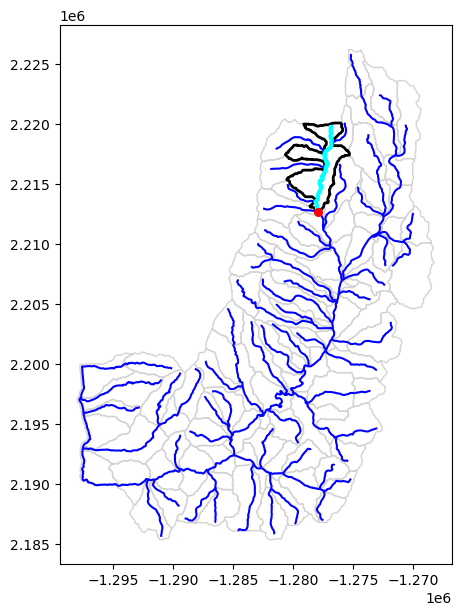

In [4]:
cat_sel = 'cat-2851642'
utils.plot_selected_region(gdf_cat, gdf_flow, gdf_nexus, cat_sel)

The selected catchment drains into nexus nex-2851643 (refer to the toid column below).

In [5]:
gdf_flow.loc[gdf_flow['divide_id']==cat_sel]

,id,toid,mainstem,order,hydroseq,lengthkm,areasqkm,tot_drainage_areasqkm,has_divide,divide_id,geometry
1,cat-2851642,nex-2851643,1957461.0,2.0,1949,8.428757,16.919099,38.386799,True,cat-2851642,"MULTILINESTRING ((-1276856.381 2219940.548, -1..."


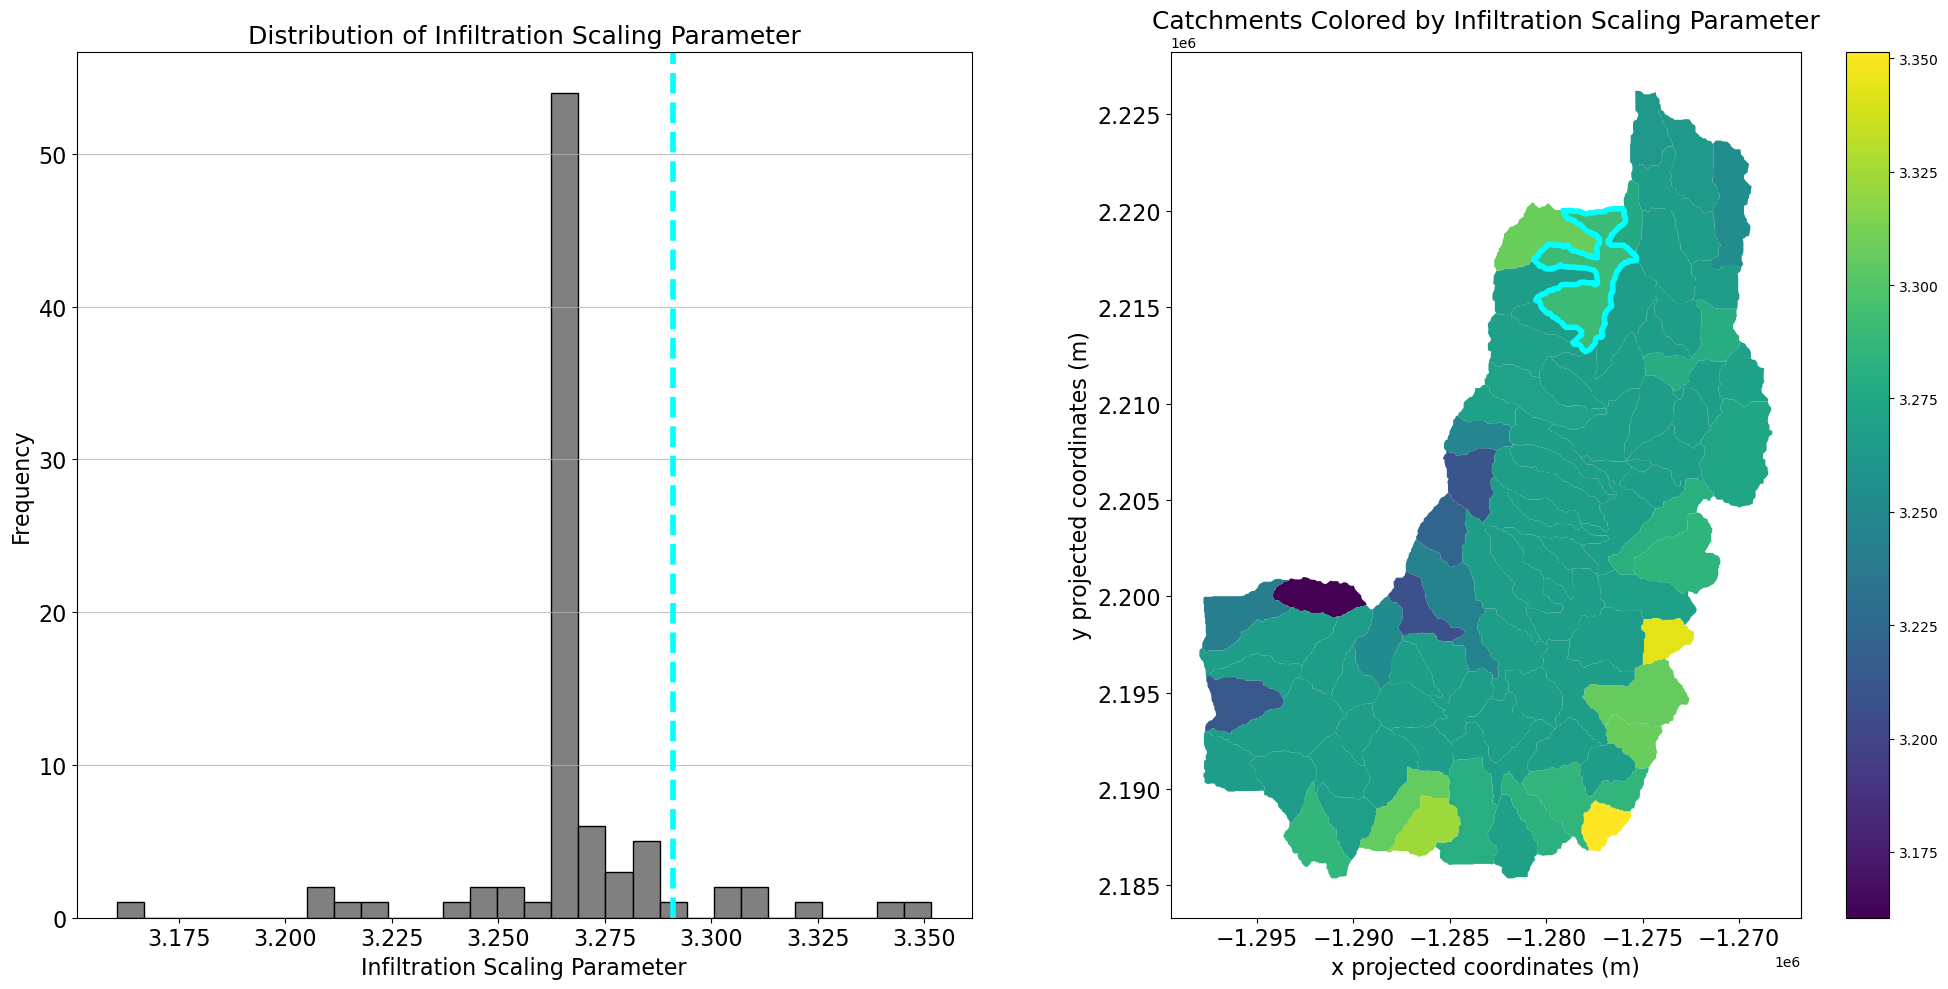

In [6]:
utils.plot_single_cat(merged, 'refkdt', 'Infiltration Scaling Parameter', 'viridis', 'cat-2851642')

In [7]:
merged.loc[merged['divide_id']==cat_sel].refkdt

1    3.290932
Name: refkdt, dtype: float64

In [8]:
config_path = base_path + 'config/' +  f'{cat_sel}_config.ini'
utils.load_config(config_path, endpoint_url, fs)

forcing_file: BMI
soil_params.depth: 2.0[m]
soil_params.b: 3.754239797592163[]
soil_params.satdk: 1.2438571325041682e-06[m s-1]
soil_params.satpsi: 0.0233870272921526[m]
soil_params.slop: 0.4666266063168737[m/m]
soil_params.smcmax: 0.5168862306583611[m/m]
soil_params.wltsmc: 0.0834221108995798[m/m]
refkdt: 3.290932
soil_params.expon: 1.0[]
soil_params.expon_secondary: 0.005[]
max_gw_storage: 248.328295278[m]
Cgw: 0.0018[m h-1]
expon: 6.0[]
gw_storage: 0.05[m/m]
alpha_fc: 0.33[]
soil_storage: 0.05[m/m]
K_nash: 0.03[]
K_lf: 0.01[]
nash_storage: 0.0,0.0
giuh_ordinates: 1.0,0.0
num_timesteps: 1
verbosity: 0
surface_partitioning_scheme: Schaake


In [9]:
nex_csvfiles = fs.glob(base_path + 'results/' + 'nex*.csv')
cat_csvfiles = fs.glob(base_path + 'results/' + 'cat*.csv')
forcing_csvfiles = fs.glob(base_path + 'forcing/' + 'cat*.csv')

xr_nex = utils.nex_csv2xr(fs, nex_csvfiles)
xr_cat = utils.cat_csv2xr(fs, cat_csvfiles)
xr_forcing = utils.forcing_csv2xr(fs, forcing_csvfiles)

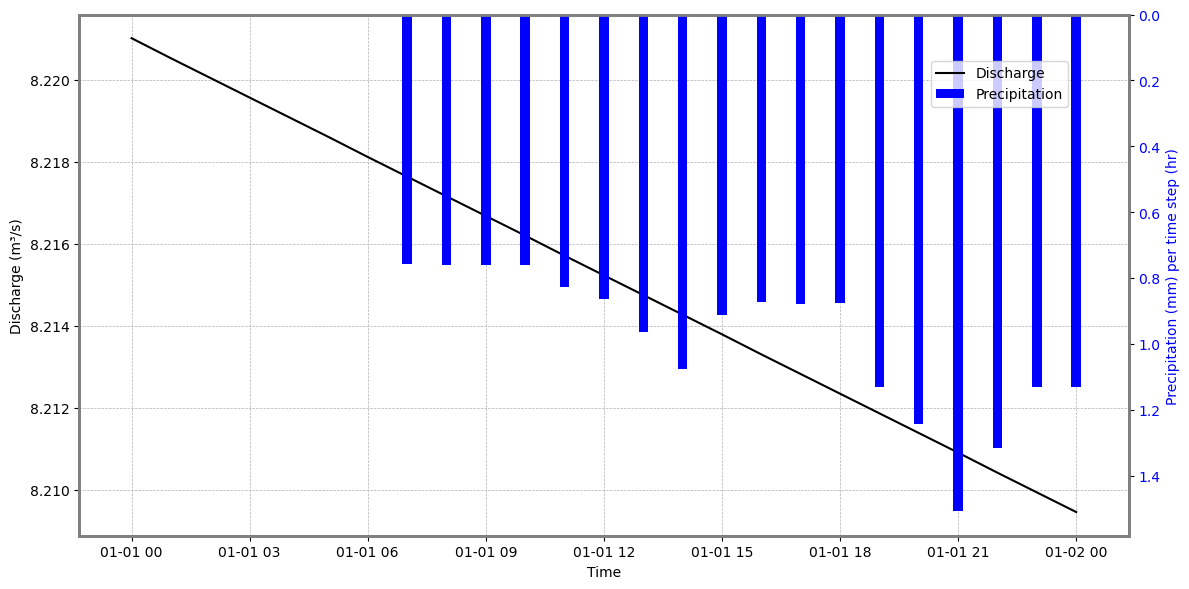

In [10]:
# Define the selected IDs and then plot precipitation and streamflow
cat_sel = 'cat-2851642'
nex_sel = gdf_flow.loc[gdf_flow['divide_id'] == cat_sel].toid.values[0]
utils.plot_precip_and_flow(cat_sel, nex_sel, xr_cat, xr_nex, xr_forcing)

In [12]:
xr_nex.to_netcdf('./outputs/sim1_nex_results_wrongforcing.nc')
xr_cat.to_netcdf('./outputs/sim1_cat_results_wrongforcing.nc')
xr_forcing.to_netcdf('./outputs/forcing_inputs_wrongforcing.nc')